# Sprint 14: Proyecto de pruebas A/B

Has recibido una tarea analítica de una tienda en línea internacional. Tus predecesores no consiguieron completarla: lanzaron una prueba A/B y luego abandonaron (para iniciar una granja de sandías en Brasil). Solo dejaron las especificaciones técnicas y los resultados de las pruebas.

**Descripción técnica**

- Nombre de la prueba: **recommender_system_test**
- Grupos: А (control), B (nuevo embudo de pago)
- Fecha de lanzamiento: 2020-12-07
- Fecha en la que dejaron de aceptar nuevos usuarios: 2020-12-21
- Fecha de finalización: 2021-01-01
- Audiencia: 15% de los nuevos usuarios de la región de la UE
- Propósito de la prueba: probar cambios relacionados con la introducción de un sistema de recomendaciones mejorado
- Resultado esperado: dentro de los 14 días posteriores a la inscripción, los usuarios mostrarán una mejor conversión en vistas de la página del producto (el evento **product_page**), instancias de agregar artículos al carrito de compras (**product_cart**) y compras (**purchase**). En cada etapa del embudo **product_page → product_cart → purchase**, habrá al menos un 10% de aumento.
- Número previsto de participantes de la prueba: 6 000

**Descripción de los datos**


- **ab_project_marketing_events_us.csv** — el calendario de eventos de marketing para 2020
- **final_ab_new_users_upd_us.csv** — todos los usuarios que se registraron en la tienda en línea desde el 7 hasta el 21 de diciembre de 2020
- **final_ab_events_upd_us.csv** — todos los eventos de los nuevos usuarios en el período comprendido entre el 7 de diciembre de 2020 y el 1 de enero de 2021
- **final_ab_participants_upd_us.csv** — tabla con los datos de los participantes de la prueba

Estructura **ab_project__marketing_events_us.csv**:

- **name** — el nombre del evento de marketing
- **regions** — regiones donde se llevará a cabo la campaña publicitaria
- **start_dt** — fecha de inicio de la campaña
- **finish_dt** — fecha de finalización de la campaña

Estructura **final_ab_new_users_upd_us.csv**:

- **user_id**
- **first_date** — fecha de inscripción
- **region**
- **device** — dispositivo utilizado para la inscripción

Estructura **final_ab_events_upd_us.csv**:

- **user_id**
- **event_dt** — fecha y hora del evento
- **event_name** — nombre del tipo de evento
- **details** — datos adicionales sobre el evento (por ejemplo, el pedido total en USD para los eventos purchase)

Estructura **final_ab_participants_upd_us.csv**:

- **user_id**
- **ab_test** — nombre de la prueba
- **group** — el grupo de prueba al que pertenecía el usuario

## Objetivo

El objetivo principal de este AB test es evaluar el impacto de un sistema de recomendaciones mejorado en el comportamiento de los usuarios dentro de un embudo de conversión de una tienda en línea. Específicamente, se quiere comprobar si el nuevo sistema logra incrementar en al menos un 10% las siguientes métricas en comparación con el grupo de control (grupo A), dentro de los 14 días posteriores a la inscripción:

Vistas de la página del producto (product_page).
Artículos agregados al carrito de compras (product_card).
Compras realizadas (purchase).

El embudo de conversión que se está midiendo es: product_page --> product_card --> purchase.

El experimento involucra un 15% de los nuevos usuarios de la región de la UE, con dos grupos:

Grupo A: Control, usuarios que siguen usando el sistema de recomendaciones actual.

Grupo B: Usuarios que interactúan con el nuevo sistema de recomendaciones.

La duración del test es del 7 de diciembre de 2020 al 1 de enero de 2021, pero los nuevos usuarios se incorporaron solo hasta el 21 de diciembre. Esto permite observar si los cambios en el sistema de recomendaciones logran influir en el comportamiento de los usuarios en las diferentes etapas del embudo.

In [1]:
# Importación de librerías

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import mannwhitneyu
import numpy as np
import math as mth
from scipy import stats
import statsmodels.api as sm

## Abrir el archivo de datos y leer la información general

In [2]:
# Descarga de los datasets

events = pd.read_csv("/datasets/ab_project_marketing_events_us.csv", parse_dates=['start_dt', "finish_dt"])
ab_new_users = pd.read_csv("/datasets/final_ab_new_users_upd_us.csv", parse_dates=['first_date'])
ab_events = pd.read_csv("/datasets/final_ab_events_upd_us.csv", parse_dates=['event_dt'])
test_participants = pd.read_csv("/datasets/final_ab_participants_upd_us.csv")

In [3]:
# Visualización de los datasets
display(events, ab_new_users, ab_events, test_participants)

,name,regions,start_dt,finish_dt
0,Christmas&New Year Promo,"EU, N.America",2020-12-25,2021-01-03
1,St. Valentine's Day Giveaway,"EU, CIS, APAC, N.America",2020-02-14,2020-02-16
2,St. Patric's Day Promo,"EU, N.America",2020-03-17,2020-03-19
3,Easter Promo,"EU, CIS, APAC, N.America",2020-04-12,2020-04-19
4,4th of July Promo,N.America,2020-07-04,2020-07-11
5,Black Friday Ads Campaign,"EU, CIS, APAC, N.America",2020-11-26,2020-12-01
6,Chinese New Year Promo,APAC,2020-01-25,2020-02-07
7,Labor day (May 1st) Ads Campaign,"EU, CIS, APAC",2020-05-01,2020-05-03
8,International Women's Day Promo,"EU, CIS, APAC",2020-03-08,2020-03-10
9,Victory Day CIS (May 9th) Event,CIS,2020-05-09,2020-05-11


,user_id,first_date,region,device
0,D72A72121175D8BE,2020-12-07,EU,PC
1,F1C668619DFE6E65,2020-12-07,N.America,Android
2,2E1BF1D4C37EA01F,2020-12-07,EU,PC
3,50734A22C0C63768,2020-12-07,EU,iPhone
4,E1BDDCE0DAFA2679,2020-12-07,N.America,iPhone
...,...,...,...,...
58698,1DB53B933257165D,2020-12-20,EU,Android
58699,538643EB4527ED03,2020-12-20,EU,Mac
58700,7ADEE837D5D8CBBD,2020-12-20,EU,PC
58701,1C7D23927835213F,2020-12-20,EU,iPhone


,user_id,event_dt,event_name,details
0,E1BDDCE0DAFA2679,2020-12-07 20:22:03,purchase,99.99
1,7B6452F081F49504,2020-12-07 09:22:53,purchase,9.99
2,9CD9F34546DF254C,2020-12-07 12:59:29,purchase,4.99
3,96F27A054B191457,2020-12-07 04:02:40,purchase,4.99
4,1FD7660FDF94CA1F,2020-12-07 10:15:09,purchase,4.99
...,...,...,...,...
423756,245E85F65C358E08,2020-12-30 19:35:55,login,NaN
423757,9385A108F5A0A7A7,2020-12-30 10:54:15,login,NaN
423758,DB650B7559AC6EAC,2020-12-30 10:59:09,login,NaN
423759,F80C9BDDEA02E53C,2020-12-30 09:53:39,login,NaN


,user_id,group,ab_test
0,D1ABA3E2887B6A73,A,recommender_system_test
1,A7A3664BD6242119,A,recommender_system_test
2,DABC14FDDFADD29E,A,recommender_system_test
3,04988C5DF189632E,A,recommender_system_test
4,4FF2998A348C484F,A,recommender_system_test
...,...,...,...
14520,1D302F8688B91781,B,interface_eu_test
14521,3DE51B726983B657,A,interface_eu_test
14522,F501F79D332BE86C,A,interface_eu_test
14523,63FBE257B05F2245,A,interface_eu_test


## Preprocesamiento de datos

In [1]:
# Función para revisión de dataset
def revision(data):
    display(data.head())
    print()
    print(data.columns)
    print()
    print(data.info())
    print()
    print(data.describe(include = "all"))
    print("Filas duplicadas: ",data.duplicated().sum())
    print(data.shape)

### events

In [5]:
revision(events)

,name,regions,start_dt,finish_dt
0,Christmas&New Year Promo,"EU, N.America",2020-12-25,2021-01-03
1,St. Valentine's Day Giveaway,"EU, CIS, APAC, N.America",2020-02-14,2020-02-16
2,St. Patric's Day Promo,"EU, N.America",2020-03-17,2020-03-19
3,Easter Promo,"EU, CIS, APAC, N.America",2020-04-12,2020-04-19
4,4th of July Promo,N.America,2020-07-04,2020-07-11



Index(['name', 'regions', 'start_dt', 'finish_dt'], dtype='object')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14 entries, 0 to 13
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   name       14 non-null     object        
 1   regions    14 non-null     object        
 2   start_dt   14 non-null     datetime64[ns]
 3   finish_dt  14 non-null     datetime64[ns]
dtypes: datetime64[ns](2), object(2)
memory usage: 576.0+ bytes
None

                             name regions             start_dt  \
count                          14      14                   14   
unique                         14       6                   14   
top     Black Friday Ads Campaign    APAC  2020-07-04 00:00:00   
freq                            1       4                    1   
first                         NaN     NaN  2020-01-25 00:00:00   
last                          NaN     NaN  2020-12-30 00:00:00   

             

- Los nombres de las columnas están de forma correcta.
- No hay valores nulos ni valores duplicados.
- Hay 6 regiones distintas.

### ab_new_users

In [6]:
revision(ab_new_users)

,user_id,first_date,region,device
0,D72A72121175D8BE,2020-12-07,EU,PC
1,F1C668619DFE6E65,2020-12-07,N.America,Android
2,2E1BF1D4C37EA01F,2020-12-07,EU,PC
3,50734A22C0C63768,2020-12-07,EU,iPhone
4,E1BDDCE0DAFA2679,2020-12-07,N.America,iPhone



Index(['user_id', 'first_date', 'region', 'device'], dtype='object')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 58703 entries, 0 to 58702
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   user_id     58703 non-null  object        
 1   first_date  58703 non-null  datetime64[ns]
 2   region      58703 non-null  object        
 3   device      58703 non-null  object        
dtypes: datetime64[ns](1), object(3)
memory usage: 1.8+ MB
None

                 user_id           first_date region   device
count              58703                58703  58703    58703
unique             58703                   17      4        4
top     CFD5206A94E51870  2020-12-21 00:00:00     EU  Android
freq                   1                 6077  43396    26159
first                NaN  2020-12-07 00:00:00    NaN      NaN
last                 NaN  2020-12-23 00:00:00    NaN      NaN
Filas duplicadas:  0
(58703, 4)


In [7]:
print("Fecha mínima:", ab_new_users["first_date"].min())
print("Fecha máxima:", ab_new_users["first_date"].max())

Fecha mínima: 2020-12-07 00:00:00
Fecha máxima: 2020-12-23 00:00:00


- Los nombres de las columnas están de forma correcta.
- No hay valores nulos ni valores duplicados.
- Hay 4 regiones distintas.
- Hay 4 dispositivos distintos.
- Hay 58,703 usuarios únicos, por tanto cada registro es un usuario
- La fecha con mas registros es el 2020-12-21

### ab_events

In [8]:
revision(ab_events)

,user_id,event_dt,event_name,details
0,E1BDDCE0DAFA2679,2020-12-07 20:22:03,purchase,99.99
1,7B6452F081F49504,2020-12-07 09:22:53,purchase,9.99
2,9CD9F34546DF254C,2020-12-07 12:59:29,purchase,4.99
3,96F27A054B191457,2020-12-07 04:02:40,purchase,4.99
4,1FD7660FDF94CA1F,2020-12-07 10:15:09,purchase,4.99



Index(['user_id', 'event_dt', 'event_name', 'details'], dtype='object')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 423761 entries, 0 to 423760
Data columns (total 4 columns):
 #   Column      Non-Null Count   Dtype         
---  ------      --------------   -----         
 0   user_id     423761 non-null  object        
 1   event_dt    423761 non-null  datetime64[ns]
 2   event_name  423761 non-null  object        
 3   details     60314 non-null   float64       
dtypes: datetime64[ns](1), float64(1), object(2)
memory usage: 12.9+ MB
None

                 user_id             event_dt event_name       details
count             423761               423761     423761  60314.000000
unique             58703               257138          4           NaN
top     A3917F81482141F2  2020-12-14 18:54:55      login           NaN
freq                  36                   10     182465           NaN
first                NaN  2020-12-07 00:00:33        NaN           NaN
last              

In [9]:
print("Fecha mínima:", ab_events["event_dt"].min())
print("Fecha máxima:", ab_events["event_dt"].max())

Fecha mínima: 2020-12-07 00:00:33
Fecha máxima: 2020-12-30 23:36:33


- Los nombres de las columnas están de forma correcta.
- No hay valores duplicados, pero hay un 85% de valores nulos en la columna "details" todos ellos relacionados a cuando el evento es "log in", por lo que tiene sentido dado que no se hace una compra, por tanto no se modificarán esos valores nulos. 
- La fecha con mas registros es el 2020-12-21
- La compra máxima es de 9.99
- La compra mínima es de 4.99

### test_participants

In [10]:
revision(test_participants)

,user_id,group,ab_test
0,D1ABA3E2887B6A73,A,recommender_system_test
1,A7A3664BD6242119,A,recommender_system_test
2,DABC14FDDFADD29E,A,recommender_system_test
3,04988C5DF189632E,A,recommender_system_test
4,4FF2998A348C484F,A,recommender_system_test



Index(['user_id', 'group', 'ab_test'], dtype='object')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14525 entries, 0 to 14524
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   user_id  14525 non-null  object
 1   group    14525 non-null  object
 2   ab_test  14525 non-null  object
dtypes: object(3)
memory usage: 340.6+ KB
None

                 user_id  group            ab_test
count              14525  14525              14525
unique             13638      2                  2
top     639050CCC2A6C4A1      A  interface_eu_test
freq                   2   8214              10850
Filas duplicadas:  0
(14525, 3)


- Los nombres de las columnas están de forma correcta.
- No hay valores nulos.
- Parece ser que hay usuarios que están repetidos, habrá que revisar si están en ambos grupos

In [11]:
# Usuarios en recommender_system_test
recommender_system_test = test_participants[test_participants["ab_test"] == "recommender_system_test" ]

# Usuarios por grupo
group_A = recommender_system_test[recommender_system_test["group"] == "A"]
group_B = recommender_system_test[recommender_system_test["group"] == "B"]

# Usuarios que se encuentran en ambos grupos
users_in_both_groups = list(set(group_A["user_id"]).intersection(set(group_B)))

print("Usuarios que están tanto en grupo A como en grupo B en prueba recommender_system_test:", len(users_in_both_groups))

Usuarios que están tanto en grupo A como en grupo B en prueba recommender_system_test: 0


In [12]:
revision(recommender_system_test)

,user_id,group,ab_test
0,D1ABA3E2887B6A73,A,recommender_system_test
1,A7A3664BD6242119,A,recommender_system_test
2,DABC14FDDFADD29E,A,recommender_system_test
3,04988C5DF189632E,A,recommender_system_test
4,4FF2998A348C484F,A,recommender_system_test



Index(['user_id', 'group', 'ab_test'], dtype='object')

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3675 entries, 0 to 3674
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   user_id  3675 non-null   object
 1   group    3675 non-null   object
 2   ab_test  3675 non-null   object
dtypes: object(3)
memory usage: 114.8+ KB
None

                 user_id group                  ab_test
count               3675  3675                     3675
unique              3675     2                        1
top     52667DF0F366C919     A  recommender_system_test
freq                   1  2747                     3675
Filas duplicadas:  0
(3675, 3)


En el dataset existen dos tipos de grupos de las pruebas A/B, dado que solo nos interesa el grupo de "recommender_system_test", dejaremos solo la información relacionada a ese grupo.

In [13]:
print("Usuarios en grupo A:", len(group_A))
print("Usuarios en grupo B:", len(group_B))

Usuarios en grupo A: 2747
Usuarios en grupo B: 928


## Análisis exploratorio de datos

In [26]:
# Unión de tabla de eventos y usuarios del test
ab_events_recommender_system_test = recommender_system_test.merge(ab_events, how = "left", on = "user_id")

# Filtro por las fechas en las que ocurre el evento
ab_events_recommender_system_test =ab_events_recommender_system_test[(
    ab_events_recommender_system_test["event_dt"] >= "2020-12-07 00:00:00") 
    & (ab_events_recommender_system_test["event_dt"] <= "2021-01-01 23:59:59")]
ab_events_recommender_system_test

,user_id,group,ab_test,event_dt,event_name,details
0,D1ABA3E2887B6A73,A,recommender_system_test,2020-12-07 14:43:27,purchase,99.99
1,D1ABA3E2887B6A73,A,recommender_system_test,2020-12-07 14:43:29,product_cart,NaN
2,D1ABA3E2887B6A73,A,recommender_system_test,2020-12-07 14:43:27,product_page,NaN
3,D1ABA3E2887B6A73,A,recommender_system_test,2020-12-07 14:43:27,login,NaN
4,A7A3664BD6242119,A,recommender_system_test,2020-12-20 15:46:06,product_page,NaN
...,...,...,...,...,...,...
23904,6715343AFBA285AE,B,recommender_system_test,2020-12-07 10:12:15,login,NaN
23905,6715343AFBA285AE,B,recommender_system_test,2020-12-08 22:51:16,login,NaN
23906,6715343AFBA285AE,B,recommender_system_test,2020-12-09 02:28:03,login,NaN
23907,6715343AFBA285AE,B,recommender_system_test,2020-12-10 22:55:14,login,NaN


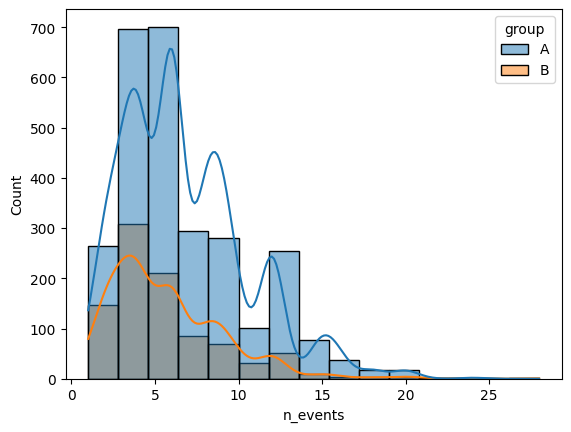

In [15]:
# Agrupación por grupo y usario para ver la distribución de los eventos por usuarios.
events_per_user = ab_events_recommender_system_test.groupby(["group","user_id"]).size().reset_index()
events_per_user.columns = ["group","user_id", "n_events"]
sns.histplot(events_per_user, x ="n_events", bins = 15, hue = "group", kde = True)
plt.show()

In [16]:
# Filtrar los datos de n_events por grupo
group_a_n_events = events_per_user[events_per_user["group"] == "A"]
group_b_n_events = events_per_user[events_per_user["group"] == "B"]

# Declaración de hipótesis
# Hipótesis nula: Ambos grupos tienen distribución equitativa de muestras iguales

# prueba de Mann-Whitney U
stat, p_value = mannwhitneyu(group_a_n_events["n_events"], group_b_n_events["n_events"], alternative='two-sided')
alpha = 0.05

print("Valor p:", p_value)

if p_value > 0.05:
    print("No se puede rechazar la hipótesis nula, hay evidencia de que ambos grupos tienen distribución equitativa")
else:
    print("Se rechaza la hipótesis nula, hay evidencia de que ambos grupos son diferentes")

Valor p: 3.625922279604957e-17
Se rechaza la hipótesis nula, hay evidencia de que ambos grupos son diferentes


Las muestras no tienen una distribución equitativa de eventos por usuario

### ¿Hay usuarios que están presentes en ambas muestras?

In [17]:
# Búsqueda de usuarios en ambos grupos mediante el método "intersection"
users_in_both_groups = list(set(group_a_n_events["user_id"]).intersection(set(group_b_n_events["user_id"])))
print("Cantidad de usuarios que están en ambos grupos:", len(users_in_both_groups))

Cantidad de usuarios que están en ambos grupos: 0


No hay usuarios en ambos grupos.

### ¿Cómo se distribuye el número de eventos entre los días?

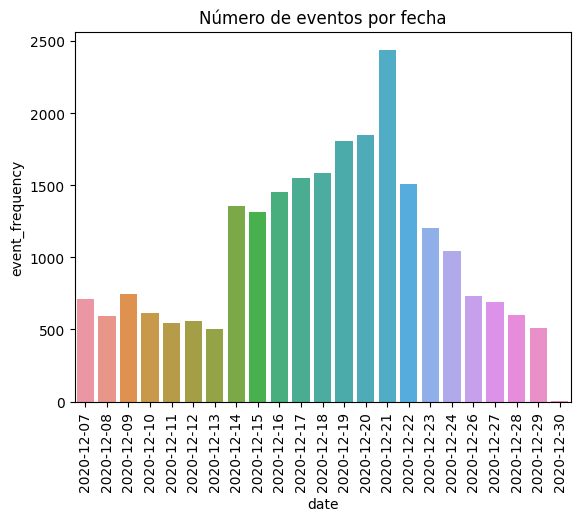

In [18]:
# Creación de columna de fecha sin hora
ab_events_recommender_system_test["date"] = ab_events_recommender_system_test["event_dt"].dt.date

# Agrupación de eventos por fecha y creación de gráfico de barras
events_per_day = ab_events_recommender_system_test.groupby("date")["event_name"].size().reset_index()
events_per_day.columns = ["date", "event_frequency"]
sns.barplot(x = events_per_day["date"], y =events_per_day["event_frequency"] )
plt.xticks(rotation=90)
plt.title("Número de eventos por fecha")
plt.show()

Se observa una mayor cantidad de eventos el día 21 de diciembre, posterior a ese día, los eventos comienzan a disminuir

### ¿Hay alguna peculiaridad en los datos que hay que tener en cuenta antes de iniciar la prueba A/B?

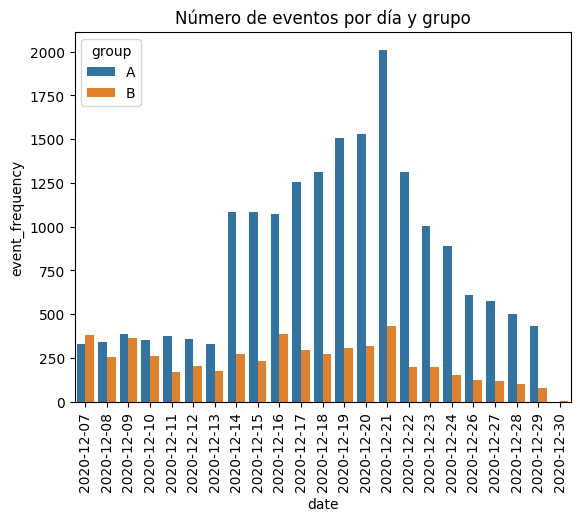

In [19]:
# Agrupación de eventos por fecha y grupo, así como creación de gráfico de barras
events_per_day_and_group = ab_events_recommender_system_test.groupby(["date", "group"])["event_name"].size().reset_index()
events_per_day_and_group.columns = ["date","group", "event_frequency"]
sns.barplot(x = events_per_day_and_group["date"], y =events_per_day_and_group["event_frequency"], hue = events_per_day_and_group["group"])
plt.xticks(rotation=90)
plt.title("Número de eventos por día y grupo")
plt.show()

Es importante considerar que los usuarios del grupo B presentan una distribución distinta de eventos, los cuales se mantuvieron siempre por debajo de los 500 eventos por día.

In [20]:
# Cálculo de la frecuencia de actividad por eventos:
events_frequency = ab_events_recommender_system_test['event_name'].value_counts().reset_index()
events_frequency.columns = ["event_name", "counts"]
display(events_frequency)

# Encontrar la cantidad de usuarios por evento:
users_per_event = ab_events_recommender_system_test.groupby('event_name')['user_id'].nunique().reset_index()
users_per_event.columns = ["event_name", "n_users"]

#Proporción de usuarios por evento
unique_users = ab_events_recommender_system_test['user_id'].nunique()
users_per_event["proportion"] = users_per_event["n_users"] / unique_users
display(users_per_event.sort_values(by = "n_users", ascending = False))

,event_name,counts
0,login,10837
1,product_page,6702
2,purchase,3210
3,product_cart,3160


,event_name,n_users,proportion
0,login,3674,0.999728
2,product_page,2303,0.626667
3,purchase,1128,0.306939
1,product_cart,1079,0.293605


## Evaluar los resultados de la prueba A/B:

In [21]:
# filtro de los eventos por usuario
group_A = ab_events_recommender_system_test[ab_events_recommender_system_test['group'] == 'A']
group_B = ab_events_recommender_system_test[ab_events_recommender_system_test['group'] == 'B']

# Usuarios únicos que realizaron la prueba
total_users_A = group_A['user_id'].nunique()
total_users_B = group_B['user_id'].nunique()

print('Total de usuarios que pertenecen al grupo A:', total_users_A)
print('Total de usuarios que pertenecen al grupo B:', total_users_B)

Total de usuarios que pertenecen al grupo A: 2747
Total de usuarios que pertenecen al grupo B: 928


In [22]:
# Ahora necesitamos resumir como se distribuyen los usuarios en cada evento para cada grupo:
summary = ab_events_recommender_system_test.groupby(['group', 'event_name']).agg({'user_id': 'nunique'}).reset_index()
summary
# summary_pivot = summary.pivot(index='event_name', columns='group', values='user_id').reset_index()

# display(summary_pivot)

,group,event_name,user_id
0,A,login,2747
1,A,product_cart,824
2,A,product_page,1780
3,A,purchase,872
4,B,login,927
5,B,product_cart,255
6,B,product_page,523
7,B,purchase,256


In [23]:
#Distribución de los usuarios por evento y grupo
summary = ab_events_recommender_system_test.groupby(['group', 'event_name'])["user_id"].nunique().reset_index()
summary_pivot = summary.pivot(index='event_name', columns='group', values='user_id').reset_index()

# Cálculo de conversión por grupo
summary_pivot['conversion_A'] = summary_pivot['A'] / total_users_A
summary_pivot['conversion_B'] = summary_pivot['B'] / total_users_B

display(summary_pivot)

group,event_name,A,B,conversion_A,conversion_B
0,login,2747,927,1.000000,0.998922
1,product_cart,824,255,0.299964,0.274784
2,product_page,1780,523,0.647980,0.563578
3,purchase,872,256,0.317437,0.275862


In [24]:
# Calcular diferencias en tasas de conversión y el incremento esperado del 10%:
summary_pivot['difference'] = summary_pivot['conversion_B'] - summary_pivot['conversion_A']
summary_pivot['expected_increase'] = summary_pivot['conversion_A'] * 0.10

display(summary_pivot)

group,event_name,A,B,conversion_A,conversion_B,difference,expected_increase
0,login,2747,927,1.000000,0.998922,-0.001078,0.100000
1,product_cart,824,255,0.299964,0.274784,-0.025179,0.029996
2,product_page,1780,523,0.647980,0.563578,-0.084402,0.064798
3,purchase,872,256,0.317437,0.275862,-0.041575,0.031744


In [25]:
# Prueba de proporciones para cada evento:
for event in summary_pivot['event_name']:
    count_A = summary_pivot[summary_pivot['event_name'] == event]['A'].values[0]
    count_B = summary_pivot[summary_pivot['event_name'] == event]['B'].values[0]
    
    z_stat, p_val = sm.stats.proportions_ztest([count_A, count_B], [total_users_A, total_users_B])
    summary_pivot.loc[summary_pivot['event_name'] == event, 'z_stat'] = z_stat
    summary_pivot.loc[summary_pivot['event_name'] == event, 'p_val'] = p_val
    
display(summary_pivot)

group,event_name,A,B,conversion_A,conversion_B,difference,expected_increase,z_stat,p_val
0,login,2747,927,1.000000,0.998922,-0.001078,0.100000,1.720737,0.085299
1,product_cart,824,255,0.299964,0.274784,-0.025179,0.029996,1.456161,0.145348
2,product_page,1780,523,0.647980,0.563578,-0.084402,0.064798,4.595797,0.000004
3,purchase,872,256,0.317437,0.275862,-0.041575,0.031744,2.374087,0.017592


## Conclusión

Revisando la diferencia de la conversión de valores, ninguna de las etapas dell embudo tiene una diferencia mayor al 10%, por tanto el z-test nos indica si son estadísticamente diferentes las proporciones, en donde login y product_car nos dab una proporción muy parecida, solamente product_page y purchase están por debajo del 0.05 para p_value, lo cual nos dice que hay diferencia en las proporciones, pero al ser negativa la diferencia de conversiones, esta nos confima que la diferencia es en la dirección contraria, por tanto:
La campaña publicitaria no dio los resultados esperados.